![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&file=TimesFM+-+Time+Series+Foundation+Model.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/TimesFM%20-%20Time%20Series%20Foundation%20Model.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520Forecasting%2FTimesFM%2520-%2520Time%2520Series%2520Foundation%2520Model.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/TimesFM%20-%20Time%20Series%20Foundation%20Model.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20Forecasting/TimesFM%20-%20Time%20Series%20Foundation%20Model.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

## TimesFM

TimesFM (Time Series Foundation Model) is a pretrained time-series foundation model developed by Google Research for time-series forecasting.

What does that mean? The training is completed, this is a model that has learned time series patterns and can do inference on input series to create forecasted horizons.  

This notebook based workflows shows how to get started directly in the notebook with:
- Setting up the enviornment:
    - This notebook in an environment - CPU method used here but GPU/TPU is available
    - The right Python version and packages - install and import the `timesfm` package
- Getting Started
    - Setup the Model
    - Make Inference using `numpy` arrays
- BigQuery Data To Pandas DataFrame
    - Prepare and make BigQuery table a local `pandas` dataframe
    - Use TimesFM to genereate horizon forecast for each times series
    - Plot history and horizon along with quantiles for predictions

Details:
- [Google Research Blog](https://research.google/blog/a-decoder-only-foundation-model-for-time-series-forecasting/)
- [GitHub repo](https://github.com/google-research/timesfm)
- [HuggingFace Model Card](https://huggingface.co/google/timesfm-1.0-200m)
- [Vertex Model Garden Model Card For TimesFM](https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/timesfm)
- [Applied AI Engineering Provided Workflow On Vertex AI](https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/research-operationalization/timesfm/README.md)


---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Not a Colab Environment


---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [3]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform', '1.51.0'),
    ('timesfm', 'timesfm'),
    ('google.cloud.bigquery', 'google-cloud-bigquery')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [4]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

inputs

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

packages:

In [4]:
import os
os.environ['JAX_PLATFORMS'] = 'cpu'

import timesfm
import numpy as np
from google.cloud import bigquery
import pandas as pd
from matplotlib import pyplot as plt

clients:

In [16]:
bq = bigquery.Client(project = PROJECT_ID)

---
## Get Started

Setup TimesFM and make an inference call like the official repositories first example:

In [5]:
tfm = timesfm.TimesFm(
    context_len=320, # multiple of 32 (input_path_len) up to 512
    horizon_len=14, # anything but < context_len recommended
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="cpu", # cpu or gpu or tpu
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 3.74 seconds.
Restoring checkpoint from /home/jupyter/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 10.06 seconds.
Jitting decoding.
Jitted decoding in 26.92 seconds.


### Example Forecast

In [11]:
forecast_input = [
    np.sin(np.linspace(0, 20, 100)),
    np.sin(np.linspace(0, 20, 200)),
    np.sin(np.linspace(0, 20, 400)),
]
#forecast_input

In [12]:
frequency_input = [0, 1, 2]
frequency_input

[0, 1, 2]

In [13]:
point_forecast, experimental_quantile_forecast = tfm.forecast(
    forecast_input,
    freq=frequency_input,
)
point_forecast

array([[ 0.98036265,  1.0065464 ,  0.97734976,  0.9273101 ,  0.8363604 ,
         0.71367764,  0.55153346,  0.36207095,  0.16936718, -0.03599859,
        -0.24321304, -0.44177842, -0.6304513 , -0.7869308 ],
       [ 0.97850287,  1.0148498 ,  1.034449  ,  1.0563511 ,  1.0543985 ,
         1.0205518 ,  0.98920697,  0.95338243,  0.9227392 ,  0.86757666,
         0.81656194,  0.75556785,  0.6789558 ,  0.5859826 ],
       [ 0.91031927,  0.93258786,  0.9457283 ,  0.9527973 ,  0.9608646 ,
         0.9583587 ,  0.97184324,  0.97845036,  0.98321855,  0.986327  ,
         0.98587453,  0.9529107 ,  0.95764846,  0.94581884]],
      dtype=float32)

In [9]:
type(tfm._model)

timesfm.patched_decoder.PatchedTimeSeriesDecoder

In [10]:
type(tfm._train_state)

paxml.train_states.TrainState

## Time Series Data: BigQuery Public Data

Similar to the other workflows in this repository, [Applied Forecasting](./readme.md), the following pulls a sample of times series from the BigQuery Public Dataset `bigquery-public-data.new_york.citibike_trips`.  A set of bike stations near New York City Central Park.  The time series are for daily demand for bikes trips starting at each station.

In [17]:
ds = bq.query(
"""
SELECT
    start_station_name,
    COUNT(*) as num_trips,
    EXTRACT(DATE FROM starttime) AS starttime
FROM bigquery-public-data.new_york.citibike_trips
WHERE start_station_name LIKE '%Central Park%'
GROUP BY start_station_name, starttime
"""
).to_dataframe()

In [18]:
ds.head()

,start_station_name,num_trips,starttime
0,Central Park West & W 72 St,168,2016-07-21
1,Central Park West & W 72 St,206,2016-05-20
2,Central Park West & W 72 St,129,2016-09-28
3,Central Park West & W 72 St,137,2016-06-08
4,Central Park West & W 72 St,134,2016-06-21


In [19]:
ds = ds.sort_values(['start_station_name', 'starttime'])
ds.head()

,start_station_name,num_trips,starttime
2755,Central Park North & Adam Clayton Powell Blvd,14,2016-09-01
767,Central Park North & Adam Clayton Powell Blvd,151,2016-09-02
2209,Central Park North & Adam Clayton Powell Blvd,255,2016-09-03
764,Central Park North & Adam Clayton Powell Blvd,328,2016-09-04
2211,Central Park North & Adam Clayton Powell Blvd,259,2016-09-05


In [20]:
ds.dtypes

start_station_name    object
num_trips              Int64
starttime             dbdate
dtype: object

In [23]:
ds['starttime'] = pd.to_datetime(ds['starttime'])

In [24]:
ds.dtypes

start_station_name            object
num_trips                      Int64
starttime             datetime64[ns]
dtype: object

start_station_name
Central Park North & Adam Clayton Powell Blvd    Axes(0.125,0.11;0.775x0.77)
Central Park S & 6 Ave                           Axes(0.125,0.11;0.775x0.77)
Central Park W & W 96 St                         Axes(0.125,0.11;0.775x0.77)
Central Park West & W 100 St                     Axes(0.125,0.11;0.775x0.77)
Central Park West & W 102 St                     Axes(0.125,0.11;0.775x0.77)
Central Park West & W 68 St                      Axes(0.125,0.11;0.775x0.77)
Central Park West & W 72 St                      Axes(0.125,0.11;0.775x0.77)
Central Park West & W 76 St                      Axes(0.125,0.11;0.775x0.77)
Central Park West & W 85 St                      Axes(0.125,0.11;0.775x0.77)
Grand Army Plaza & Central Park S                Axes(0.125,0.11;0.775x0.77)
W 106 St & Central Park West                     Axes(0.125,0.11;0.775x0.77)
W 82 St & Central Park West                      Axes(0.125,0.11;0.775x0.77)
Name: num_trips, dtype: object

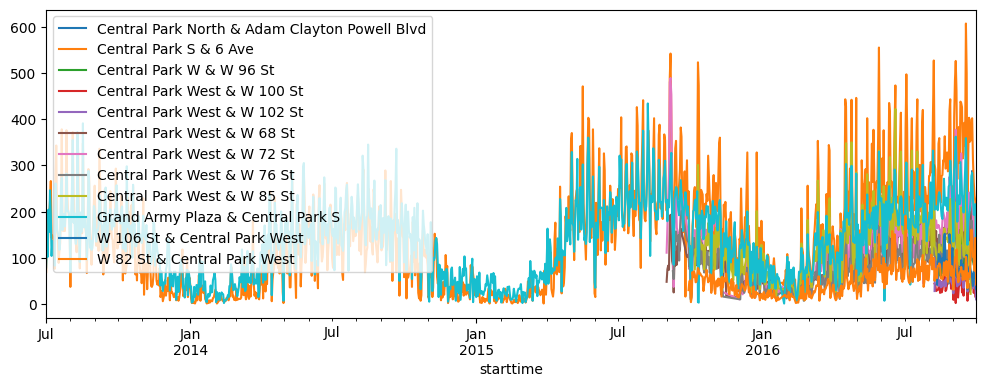

In [25]:
ds.set_index('starttime').groupby('start_station_name')['num_trips'].plot(legend = 'True', figsize = (12, 4))

## TimeFM Forecasting

TimeFM has built in method, `.forecast_on_df` that takes input dataframes and creates forecast for each series.  The requirment for this input dataframe are:
- a date/time column named `ds`
- a time series name column named `unique_id`

The other inputs are:
- `freq` to indicate the frequency of the `ds` column
- `value_name` to indicate the column with the demand values for forecasting
- `num_jobs` to limit the number of series forecasted asynchronously. 
    - -1 would detect the availabe cpus as the number of parallel operations
    - 1 would limit to synchronous processing
    
The resulting forcast contain the `unique_id` and `ds` columns with date for each horizon date/time indicated by the model setup above.  Additionally:
- `timesfm` has the forecasted demand
- each of the `times-fm-q-0.x` column has relative quantile for the forecasted demand: 0.1 to 0.9 in 0.1 increments where `times-fm-q-0.5` = `timesfm`

In [26]:
forecast_ds = tfm.forecast_on_df(
    inputs = ds.rename(columns = {'start_station_name':'unique_id', 'starttime':'ds'}),
    freq = "D",
    value_name = 'num_trips',
    num_jobs = 1
).rename(columns = {'unique_id':'start_station_name', 'ds':'starttime'})

Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


In [27]:
forecast_ds

,start_station_name,starttime,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,Central Park North & Adam Clayton Powell Blvd,2016-10-01,174.511215,86.250061,114.290413,137.087387,152.961609,174.511215,189.215424,211.085724,235.449249,273.403656
1,Central Park North & Adam Clayton Powell Blvd,2016-10-02,195.588684,102.024055,132.929413,158.308853,178.316208,195.588684,214.450668,237.098877,264.609955,305.413422
2,Central Park North & Adam Clayton Powell Blvd,2016-10-03,127.366943,49.790356,75.799660,92.254425,110.489296,127.366943,142.884171,159.846115,183.560455,218.723648
3,Central Park North & Adam Clayton Powell Blvd,2016-10-04,118.898041,43.948441,70.978577,85.443474,103.091187,118.898041,132.244293,151.328003,171.303894,203.432999
4,Central Park North & Adam Clayton Powell Blvd,2016-10-05,116.745010,41.674950,66.923897,84.363770,102.076302,116.745010,131.133331,150.160126,168.762146,203.412140
...,...,...,...,...,...,...,...,...,...,...,...,...
163,W 82 St & Central Park West,2016-10-10,70.920387,40.020611,50.068714,57.712025,63.882038,70.920387,78.232430,87.138397,98.302025,118.398270
164,W 82 St & Central Park West,2016-10-11,67.841820,38.452408,47.574390,54.538532,61.379364,67.841820,74.842979,83.038361,94.236801,113.169380
165,W 82 St & Central Park West,2016-10-12,68.339630,38.150017,47.794407,54.822407,61.444416,68.339630,75.411957,83.935738,94.855888,114.507095
166,W 82 St & Central Park West,2016-10-13,66.324203,36.997688,46.106972,53.556335,59.955372,66.324203,73.828568,81.707184,92.927025,112.454491


start_station_name
Central Park North & Adam Clayton Powell Blvd    Axes(0.125,0.11;0.775x0.77)
Central Park S & 6 Ave                           Axes(0.125,0.11;0.775x0.77)
Central Park W & W 96 St                         Axes(0.125,0.11;0.775x0.77)
Central Park West & W 100 St                     Axes(0.125,0.11;0.775x0.77)
Central Park West & W 102 St                     Axes(0.125,0.11;0.775x0.77)
Central Park West & W 68 St                      Axes(0.125,0.11;0.775x0.77)
Central Park West & W 72 St                      Axes(0.125,0.11;0.775x0.77)
Central Park West & W 76 St                      Axes(0.125,0.11;0.775x0.77)
Central Park West & W 85 St                      Axes(0.125,0.11;0.775x0.77)
Grand Army Plaza & Central Park S                Axes(0.125,0.11;0.775x0.77)
W 106 St & Central Park West                     Axes(0.125,0.11;0.775x0.77)
W 82 St & Central Park West                      Axes(0.125,0.11;0.775x0.77)
Name: timesfm, dtype: object

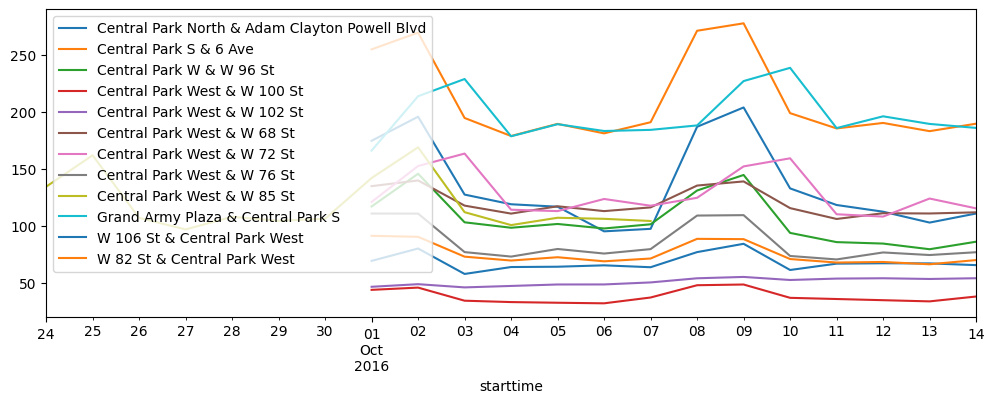

In [28]:
forecast_ds.set_index('starttime').groupby('start_station_name')['timesfm'].plot(legend = 'True', figsize = (12, 4))

## Visualize Time Series With Forecast And Quantiles

Plot each time series with the history, the forecast horzion, and quantile bands around the forecast for the horizon.

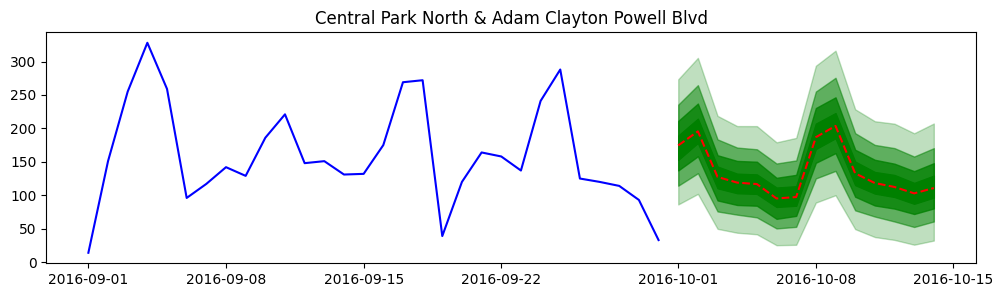

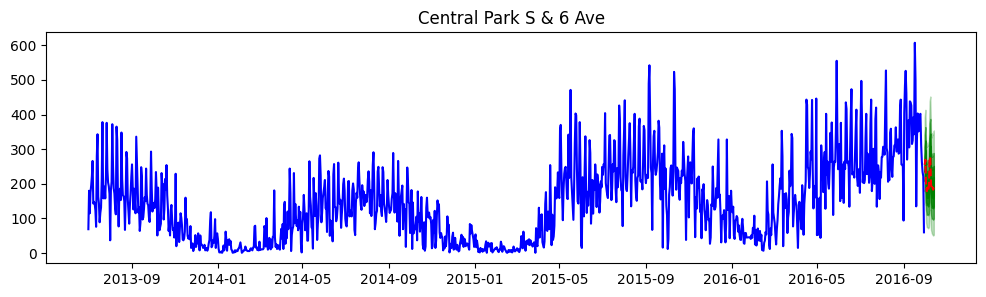

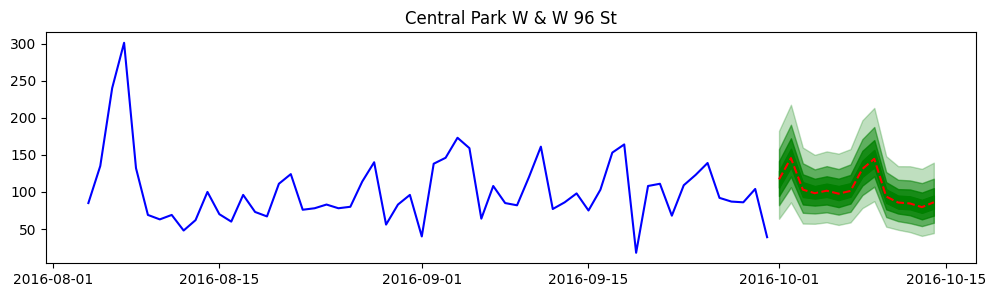

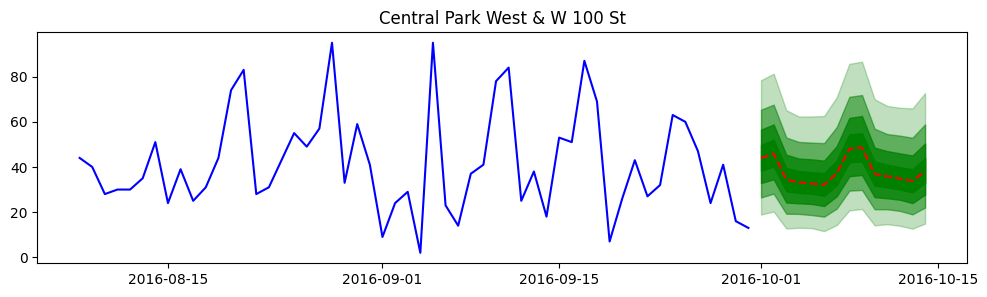

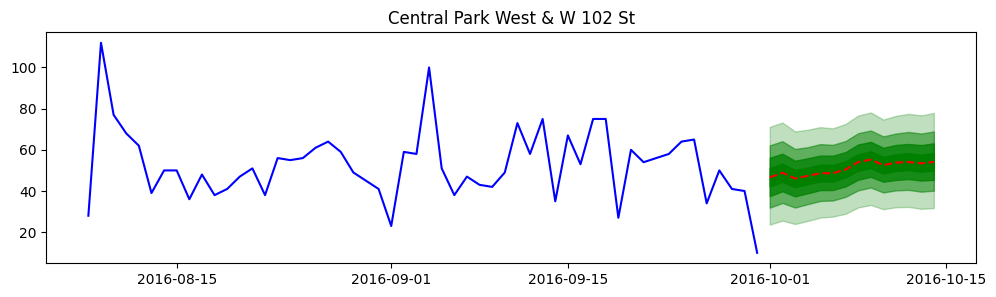

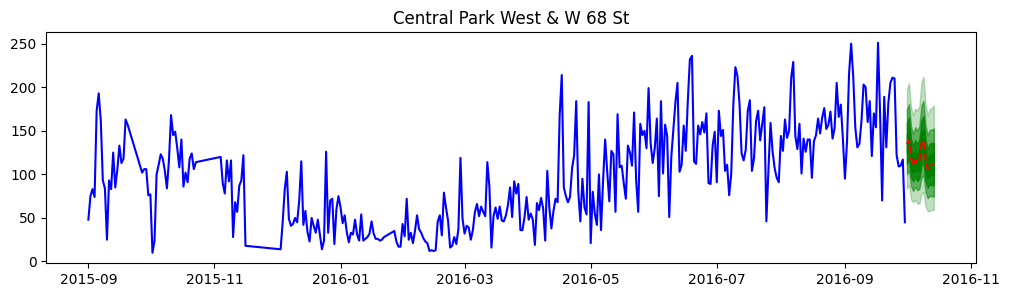

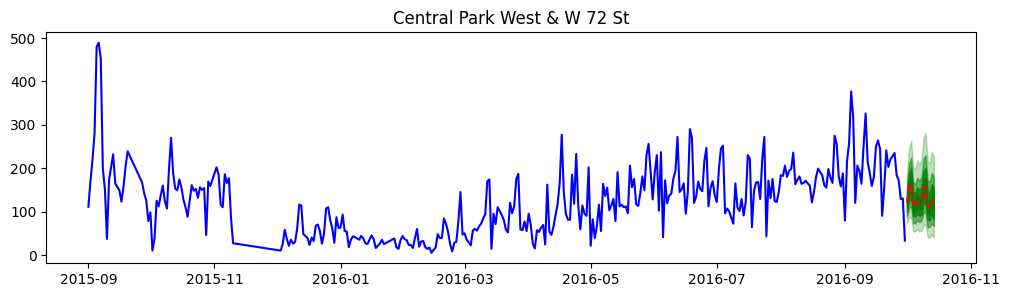

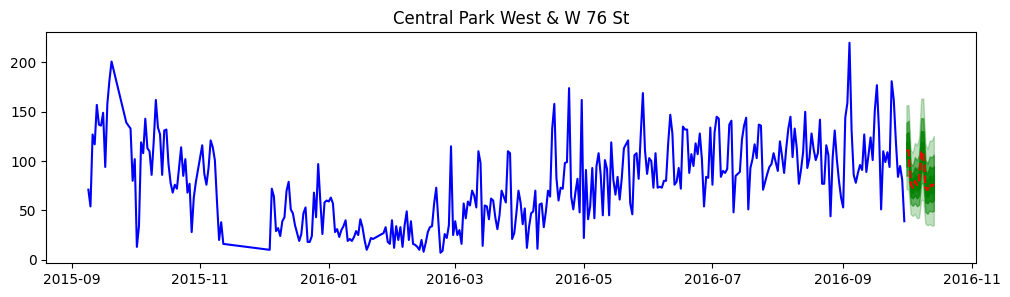

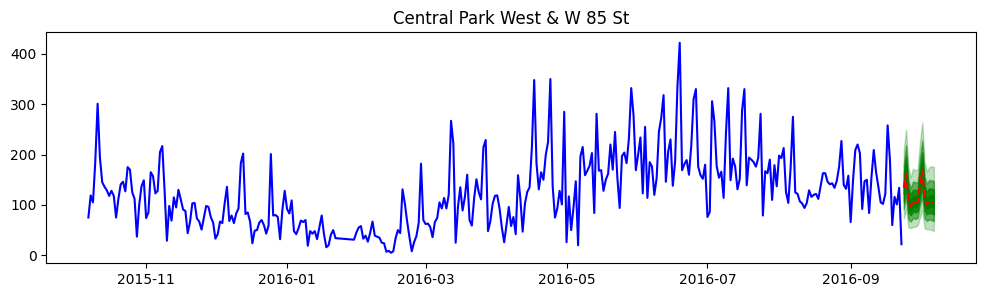

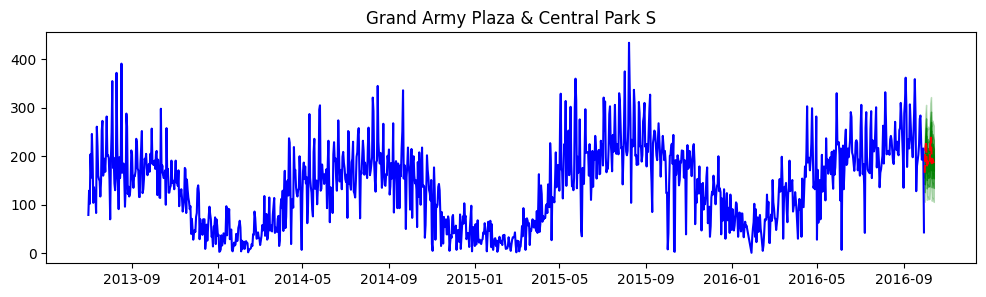

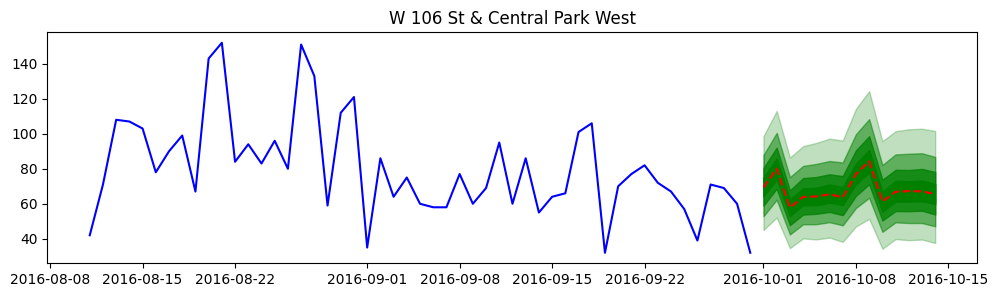

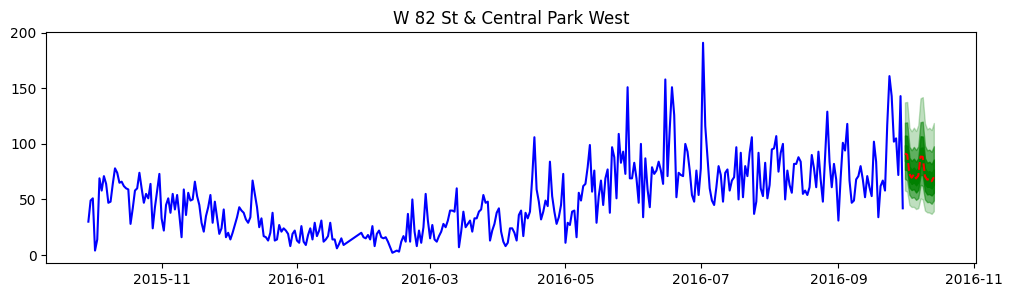

In [32]:
for station in ds['start_station_name'].unique():
    history = ds[ds['start_station_name'] == station].set_index('starttime')
    horizon = forecast_ds[forecast_ds['start_station_name'] == station].set_index('starttime')

    plt.figure(figsize = (12,3))
    plt.plot(history['num_trips'], linestyle = '-', color = 'blue')
    plt.plot(horizon['timesfm'], linestyle = '--', color = 'red')
    plt.fill_between(horizon.index, horizon['timesfm-q-0.4'], horizon['timesfm-q-0.6'], color = 'green', alpha = 1)
    plt.fill_between(horizon.index, horizon['timesfm-q-0.3'], horizon['timesfm-q-0.7'], color = 'green', alpha = 0.75)
    plt.fill_between(horizon.index, horizon['timesfm-q-0.2'], horizon['timesfm-q-0.8'], color = 'green', alpha = 0.5)
    plt.fill_between(horizon.index, horizon['timesfm-q-0.1'], horizon['timesfm-q-0.9'], color = 'green', alpha = 0.25)
    plt.title(station)
    plt.show()